In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [102]:
results = pd.read_csv(r'D:\f1 top 10\Data\results.csv')
races = pd.read_csv(r'D:\f1 top 10\Data\races.csv')
constructors = pd.read_csv(r'D:\f1 top 10\Data\constructors.csv')

In [103]:
results["TOP10"] = results["positionOrder"].apply(lambda x: 1 if x <= 10 else 0)

In [104]:
results_clean = results[[
    "raceId",
    "constructorId",
    "grid",
    "TOP10"
]].copy()


In [105]:
df = results_clean.merge(
    constructors[["constructorId", "name"]],
    on="constructorId",
    how="left"
)

df = df.rename(columns={"name": "constructor_name"})


In [106]:
constructor_history = df.groupby("constructor_name")["TOP10"].mean().reset_index()
constructor_history = constructor_history.rename(
    columns={"TOP10": "Constructor_Top10_Rate"}
)

df = df.merge(constructor_history, on="constructor_name", how="left")


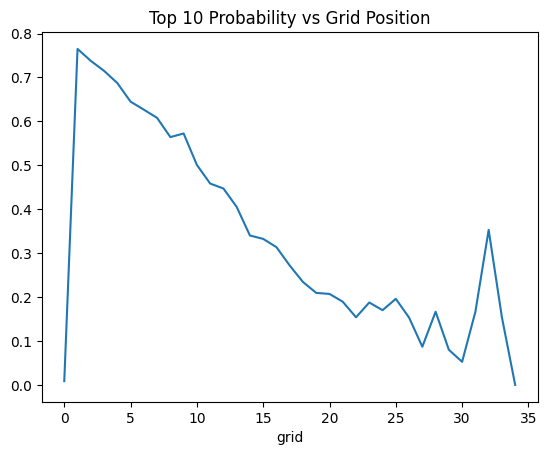

In [107]:
grid_performance = df.groupby("grid")["TOP10"].mean()

plt.figure()
grid_performance.plot()
plt.title("Top 10 Probability vs Grid Position")
plt.show()


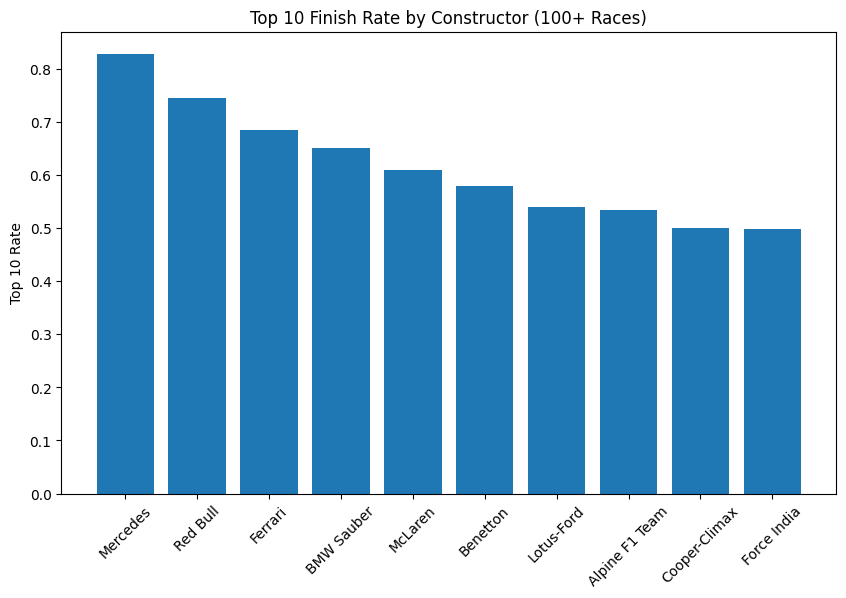

In [ ]:
constructor_stats = df.groupby("constructor_name").agg(
    Top10_Rate=("TOP10", "mean"),
    Total_Races=("TOP10", "count")
).reset_index()

constructor_stats = constructor_stats[constructor_stats["Total_Races"] >= 100]

constructor_stats = constructor_stats.sort_values("Top10_Rate", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(constructor_stats["constructor_name"].head(10),
        constructor_stats["Top10_Rate"].head(10))
plt.xticks(rotation=45)
plt.title("Top 10 Finish Rate by Constructor (100+ Races)")
plt.ylabel("Top 10 Rate")
plt.show()


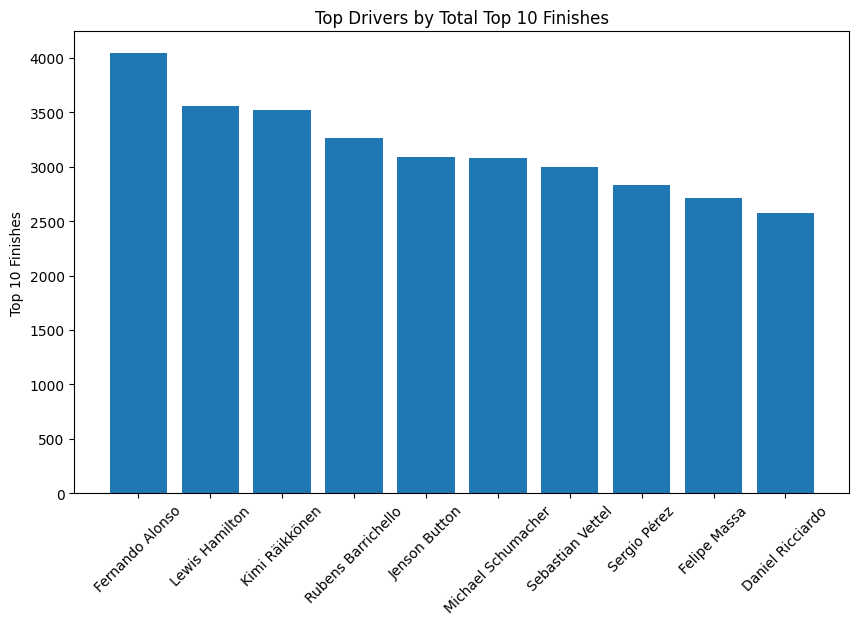

In [111]:

drivers = pd.read_csv(r'D:\f1 top 10\Data\drivers.csv')
drivers["driverName"] = drivers["forename"] + " " + drivers["surname"]

df = df.merge(
    results[["raceId", "driverId"]],
    on="raceId",
    how="left"
)

df = df.merge(
    drivers[["driverId", "driverName"]],
    on="driverId",
    how="left"
)

driver_stats = df.groupby("driverName").agg(
    Top10_Count=("TOP10", "sum"),
    Total_Races=("TOP10", "count")
).reset_index()

driver_stats = driver_stats[driver_stats["Total_Races"] >= 100]
driver_stats = driver_stats.sort_values("Top10_Count", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(driver_stats["driverName"].head(10),
        driver_stats["Top10_Count"].head(10))
plt.xticks(rotation=45)
plt.title("Top Drivers by Total Top 10 Finishes")
plt.ylabel("Top 10 Finishes")
plt.show()


In [108]:
df_model = df[df["grid"] > 0].copy()

X = df_model[["grid", "Constructor_Top10_Rate"]]
y = df_model["TOP10"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [109]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6823880597014925
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      2797
           1       0.65      0.63      0.64      2228

    accuracy                           0.68      5025
   macro avg       0.68      0.68      0.68      5025
weighted avg       0.68      0.68      0.68      5025



In [112]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring="accuracy"
)

grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Score: 0.6905849330109839
